# Introduction

This notebook is divided into two parts:

__Part I - Prepocessing of images__, was applied as such for all the models we used for training the emotion detection. Therefore the same code is also built into other jupyter notebooks. The coede is taken from the notebook 'Load Emotion Detection_CNN.ipynb'

__Part II - Emotion detection by using VGG16__  

VGG16 is a deep convolutional neural network architecture used for image classification tasks. It consists of 16 layers, including convolutional and fully connected layers, and is known for its simplicity and effectiveness. VGG16 is widely used as a feature extractor or a pre-trained model for various computer vision tasks.


The model was trained in five iterations, each with the goal to get better accuracy by fine-tuning. Each iteration contains the complete code and is therefore a repetition, however this is done intentionally in order to keep the output of the model such as the summary with the description of all layers and the graphs for training and evaluation accuracy and training and evaluation loss.
The runtime of the models took up to more than 8 hours.

Each iteration of emotion detection consist roughly of following steps:  
- transformation from 1 to 3 channels  
- define hyperparamters  
- define layers to be frozen  
- adding custom layers  
- train and evaluate the model
- save the model for later use


# Part I - Preprocessing of the images

In [ ]:
#!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)


In [2]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load data

In [ ]:
# run locally
#base_path = r'C:\Users\steff\OneDrive - Hochschule Luzern\Dokumente\HSLU\Computer Vision\Project CV all\Emotion Classification\data\images\images\train'
#base_path = r'C:\Users\eli\Nextcloud\HSLU\Vorlesungen\Computer_Vision_CVI03\Project\images\images\train'   # Desktop E


In [3]:
# Basis-Dateipfad

def read_data(base_path):
    # Liste der Ordner mit Labels
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]

    # Initialisiere leere Listen für Bilder und Labels
    df=pd.DataFrame(columns=["images","labels"])

    # Iteriere durch die Ordner und sammle Bilder und Labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                # Öffne das Bild und speichere es im RGB-Format
                image = Image.open(image_path)#.convert('RGB')
                # Wandele das Bild in ein NumPy-Array um
                image = np.array(image)
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1

    return df


In [ ]:
# run locally
#train_path = './images/train'
#test_path = './images/validation'
#train_df = read_data(train_path)
#test_df=read_data(test_path)
#df=pd.concat([train_df,test_df])

In [4]:
# run on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# run on colab
#train_path = '../Data/Emotions/train'
#test_path = '../Data/Emotions/validation'

train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation'
#train_df = read_data(train_path)
test_df=read_data(test_path)
#df=pd.concat([train_df,test_df])


In [6]:
df=test_df

## Plotting the images

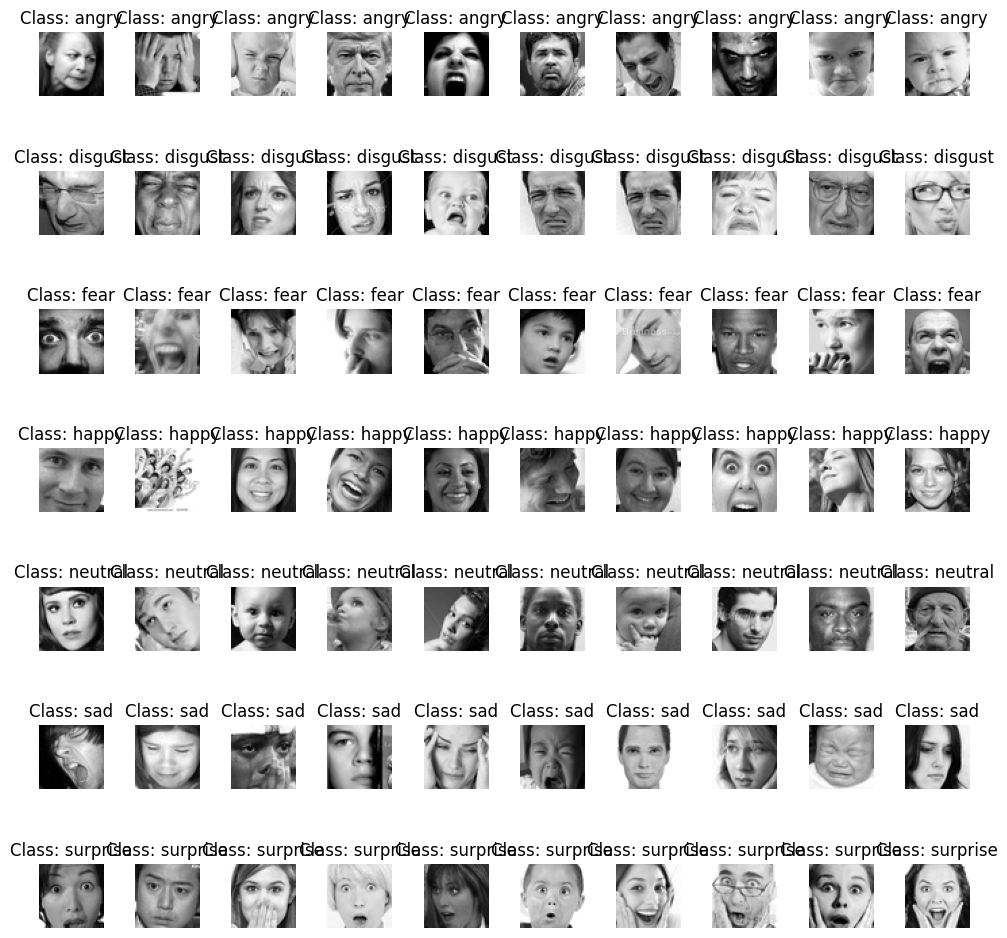

In [7]:
classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<Axes: xlabel='labels'>

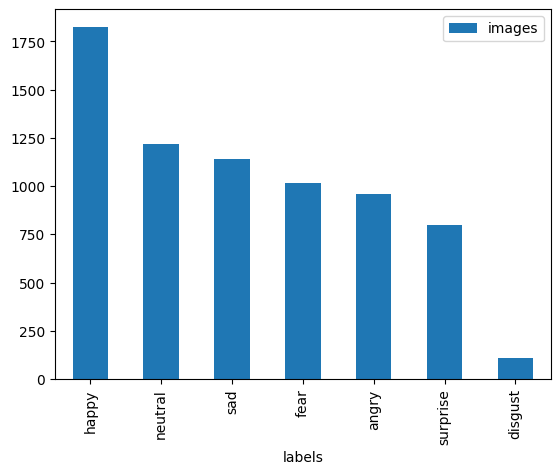

In [8]:
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [9]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

## Oversampling

In [10]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

In [11]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)

In [12]:
train_oversampled

,images,labels
7710,"[[125, 74, 82, 50, 34, 30, 25, 38, 56, 75, 94,...",neutral
4426,"[[80, 84, 99, 104, 88, 68, 77, 77, 79, 75, 90,...",angry
5094,"[[77, 64, 69, 76, 82, 69, 41, 49, 60, 114, 190...",angry
2930,"[[17, 22, 46, 203, 232, 228, 229, 231, 234, 23...",sad
8419,"[[66, 59, 44, 19, 67, 60, 60, 82, 86, 79, 83, ...",surprise
...,...,...
4373,"[[19, 19, 25, 8, 2, 8, 4, 14, 22, 17, 13, 16, ...",angry
7891,"[[110, 125, 106, 113, 118, 108, 117, 129, 129,...",sad
4859,"[[47, 45, 27, 29, 24, 30, 34, 20, 28, 49, 77, ...",happy
3264,"[[90, 95, 86, 97, 92, 91, 94, 88, 85, 95, 88, ...",neutral


<Axes: xlabel='labels'>

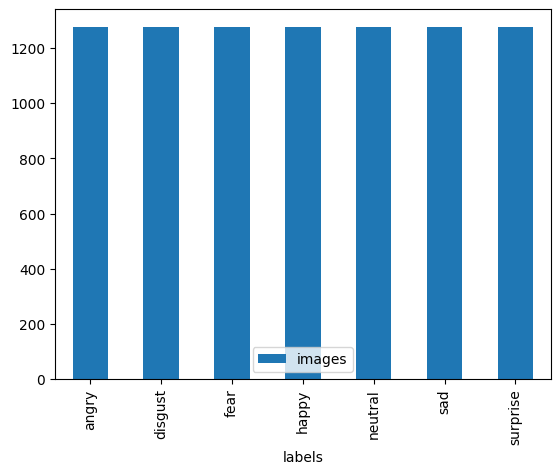

In [13]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

## Data Augmentation

In [14]:
 train_datagen = ImageDataGenerator(

        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator(
      # rescale the pixel values (between 0 and 255) to the [0,1] interval
       rescale=1./255
)

## Conversions to input format for models

In [15]:
np.array(train_oversampled['labels'])

array(['neutral', 'angry', 'angry', ..., 'happy', 'neutral', 'neutral'],
      dtype=object)

In [16]:
# Schritt 1: "images" in einen NumPy ndarray umwandeln
X_train = np.array(train_oversampled['images'].tolist())

# Schritt 2: "labels" in einen NumPy ndarray umwandeln
y_train = np.array(train_oversampled['labels'])

# Überprüfung der Form der erstellten Arrays
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (8939, 48, 48)
Shape von y_train: (8939,)


In [17]:
train_oversampled['labels']

7710     neutral
4426       angry
5094       angry
2930         sad
8419    surprise
          ...   
4373       angry
7891         sad
4859       happy
3264     neutral
2732     neutral
Name: labels, Length: 8939, dtype: object

In [18]:
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [19]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [20]:
X_train_plot.shape

(1, 48, 48, 1)

In [21]:
y_train_cat=to_categorical(y_train)
y_train_cat


array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [22]:
y_val_cat=to_categorical(y_val)
y_val_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

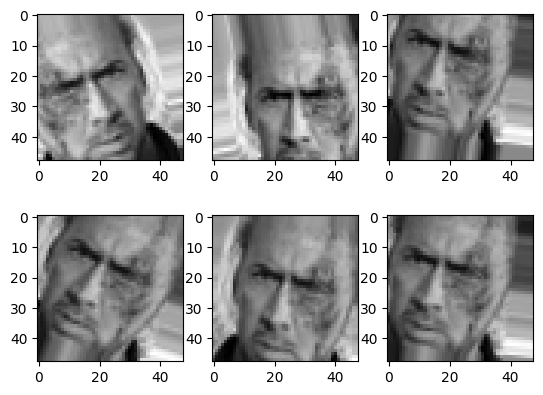

In [23]:
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)

### Up to here, the same preparatory steps were done as for the other emotion detection models.

# Part II - Emotion detection by using VGG16

Insights to VGG16:
https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918     

## Comparison of the models and final choice

Below is the overview of the five runs of VGG16() with its evaluation metrics and runtime.

In the __first run__, all layers of the pretrained model were frozen and four additional layers were added. The model was trained in 10 epochs and resulted in an accuracy of 0.3455. The curves in the graphs of the evaluation metrics do not transition into a horizontal line on the right edge. This means that further epochs might improve accuracy.

As enhancement for the __second run__, 4 layers at the end of the pretrained model were set as trainable (and not frozen as in the previous run). This prolonged the running time from about 20 minutes of the first run to about 50 minutes. The accuracy improved to 0.5724 and the curves of validation accuracy and validation loss turn into a more horizontal line at the right edge.

The __third run__ was trained 9 additional layers, keeping the four last layers of VGG16() as trainable. The epochs have been raised from 10 to 100, which resulted in a runtime of more than 8 hours. The accuracy improved to 0.7598 but the metrics graphs show overfitting.

To reduce  overfitting, the dropout rate was set from 0.3 to 0.5 in the __fourth run__, and L2-Regualtization was introduced. The accuracy is 0.7644 and the metric graphs still show overfitting.

For the __fifth run__, the number of filters in the Conv2D-layer were reduced from 128 to 64 and the number of neurons in the Dense-layer were reduced from 256 to 128. In addition the dropout rate was increased to 0.7 (from previously 0.5). With those adaptions, the overfitting could be reduced as can be seen in the evaluation graphs, but this model reduces the accuracy = 0.6748 as well.

For our final style transfer on pictures with detected faces and their emotions, the fourth model was chosen as it had best performance despite of showing more overfitting.

In [ ]:
# Overview of metrics and runtime of the models

# for 1st run:
# Epoch 10/10
# 1102/1102 [==============================] - 140s 127ms/step -
# loss: 1.6683 - accuracy: 0.3507 - val_loss: 1.6371 - val_accuracy: 0.3647
# Epoch 10/10
# 1102/1102 [==============================] - 130s 118ms/step -
# loss: 1.7174 - accuracy: 0.3326 - val_loss: 1.6921 - val_accuracy: 0.3455
# Duration of model-fit in minutes: 21.6078

# for 2nd run:
# Epoch 10/10
# 1102/1102 [==============================] - 304s 276ms/step -
# loss: 1.0942 - accuracy: 0.5903 - val_loss: 1.1315 - val_accuracy: 0.5724
# Duration of model-fit in minutes: 51.3443

# for 3rd try:
# Epoch 100/100
# 1102/1102 [==============================] - 283s 257ms/step -
# loss: 0.3115 - accuracy: 0.8947 - val_loss: 0.8834 - val_accuracy: 0.7598
# Duration of model-fit in minutes: 509.6655

# for 4th try:
# for 4th try:
# Epoch 100/100
# 1102/1102 [==============================] - 285s 259ms/step -
# loss: 0.3134 - accuracy: 0.9001 - val_loss: 0.8656 - val_accuracy: 0.7644
# Duration of model-fit in minutes: 457.1054

# for 5th try:
# Epoch 100/100
# 1102/1102 [==============================] - 275s 249ms/step -
# loss: 0.7875 - accuracy: 0.7455 - val_loss: 0.9641 - val_accuracy: 0.6748
# Duration of model-fit in minutes: 457.1054

# Code for all five iterations:

VGG16 expects the input to be 224x224x3. As we have greyscale images to train on having only one channel, we replicate this one channel to three channels.
The size of our images (48x48) will not be adapted (resized). An attempt to resize the images to 224x224 was made after the thrid run of the model, but was then given up and not finalized, as I continouosly got a 'ResourceExhaustedError'.

# First run: all layers freezed, 10 epochs, 4 additional layers

In [27]:
# load libraries

import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

VGG16 expects the input to be 224x224x3. As we have greyscale images to train on haveing only one channel, we replicate this one channel to three channels.
The size of our images (48x48) will only be adapted in the fourth run.

In [27]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

In [24]:
# 1st and 2nd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7
learning_rate = 0.0001
batch_size = 32
epochs = 10

In [28]:
# train and test-generator
train_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)


In [36]:

validation_generator = train_datagen.flow(
    x=X_val_rgb,
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

(1484, 1484)

In [37]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [38]:
# 1-st run: Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [39]:
# 1st and 2nd run: Add custom layers for emotion classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [44]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [45]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()

Epoch 1/10
224/224 [==============================] - 19s 70ms/step - loss: 1.7527 - accuracy: 0.3203 - val_loss: 1.7859 - val_accuracy: 0.2872
Epoch 2/10
224/224 [==============================] - 11s 49ms/step - loss: 1.7423 - accuracy: 0.3249 - val_loss: 1.8048 - val_accuracy: 0.2804
Epoch 3/10
224/224 [==============================] - 9s 40ms/step - loss: 1.7372 - accuracy: 0.3221 - val_loss: 1.7804 - val_accuracy: 0.3007
Epoch 4/10
224/224 [==============================] - 11s 47ms/step - loss: 1.7293 - accuracy: 0.3240 - val_loss: 1.7770 - val_accuracy: 0.2838
Epoch 5/10
224/224 [==============================] - 11s 47ms/step - loss: 1.7202 - accuracy: 0.3324 - val_loss: 1.8016 - val_accuracy: 0.2770
Epoch 6/10
224/224 [==============================] - 9s 41ms/step - loss: 1.7139 - accuracy: 0.3324 - val_loss: 1.7372 - val_accuracy: 0.3074
Epoch 7/10
224/224 [==============================] - 11s 48ms/step - loss: 1.7088 - accuracy: 0.3413 - val_loss: 1.7562 - val_accuracy: 0

In [47]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))
# Duration of model-fit in minutes: 21.6078

Duration of model-fit in minutes: 2.1695


In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

## 1st run:

Model: "model"
_________________________________________________________________  


###  Layer (type)                Output Shape              Param #   
=================================================================    
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================   

Total params: 14,847,815  
Trainable params: 133,127  
Non-trainable params: 14,714,688  
_________________________________________________________________

In [49]:
# 1st run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

# Training Accuracy: 0.3326
# Validation Accuracy: 0.3455
# Training Loss: 1.8324
# Validation Accuracy: 1.7829

Training Accuracy: 0.3463
Validation Accuracy: 0.277 

Training Loss: 1.7423
Validation Accuracy: 1.8048


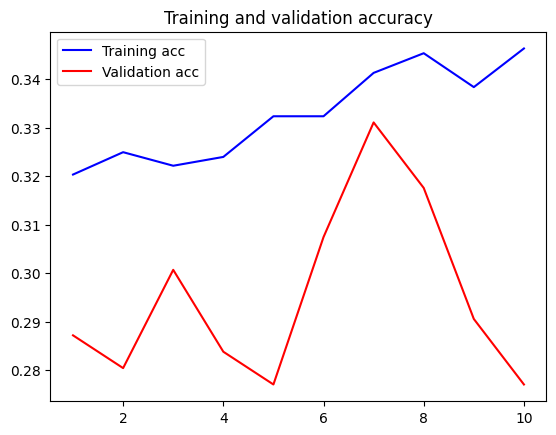

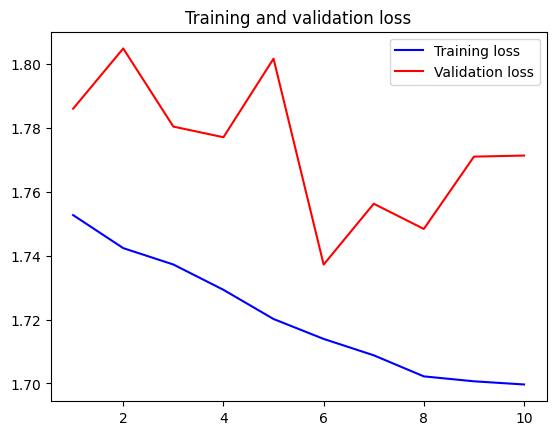

In [50]:
# plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
model.evaluate(X_val_rgb, y_val_cat)

47/47 [==============================] - 1s 16ms/step - loss: 17.0308 - accuracy: 0.2183


[17.030826568603516, 0.2183288335800171]

In [ ]:
# Save the model for future inference
# run locally
#model.save('1st_run_VGG16_model.h5')
# run on colab
model.save('../Model/1st_run_VGG16_model.h5')

# Second run: 4 trainable layers at the end, 10 epochs, 4 additional layers

In [ ]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

In [ ]:
# 1st and 2nd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7
learning_rate = 0.0001
batch_size = 32
epochs = 10

In [ ]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [ ]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# 2nd run: only freezing layers at the beginning and fine-tune some of the later layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# 1st and 2nd run: Add custom layers for emotion classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
start = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()

In [ ]:
model.summary()

### 2nd run:

Model: "model_2"
_________________________________________________________________
### Layer (type)                Output Shape              Param #    
=================================================================    
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 14,847,815  
Trainable params: 7,212,551  
Non-trainable params: 7,635,264  
_________________________________________________________________



In [ ]:
# 2nd run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

In [ ]:
# 2nd run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Save the model for future inference
# run locally
#model.save('2nd_run_VGG16_model.h5')
# run on colab
model.save('../Model/2nd_run_VGG16_model.h5')


# Third run: 4 trainable layers at the end, add more additional layers, 100 epochs

In [ ]:
# 3rd run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7
learning_rate = 0.0001
batch_size = 32
epochs = 100

In [ ]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [ ]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# 1-st run: Freeze all layers of the base model
#for layer in base_model.layers:
#    layer.trainable = False

In [ ]:
# 2nd and 3rd try: freeze layers at the beginning and fine-tune the last 4 layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# 3rd run: add custom layers for emotion classification
x = Conv2D(128, (3,3),padding = 'same')(base_model.output)       # oder Conv1D(128, (3,3),padding = 'same')(base_model.output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# 1st try and 2-nd try and 3rd try: Compile the model

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# for 1st try:
# Epoch 10/10
# 1102/1102 [==============================] - 140s 127ms/step -
# loss: 1.6683 - accuracy: 0.3507 - val_loss: 1.6371 - val_accuracy: 0.3647

# for 2nd try:
# Epoch 10/10
# 1102/1102 [==============================] - 304s 276ms/step -
# loss: 1.0942 - accuracy: 0.5903 - val_loss: 1.1315 - val_accuracy: 0.5724

# for 3rd try:
# Epoch 100/100
# 1102/1102 [==============================] - 283s 257ms/step -
# loss: 0.3115 - accuracy: 0.8947 - val_loss: 0.8834 - val_accuracy: 0.7598

# for 4th try:
# Epoch 100/100
# 1102/1102 [==============================] - 285s 259ms/step -
# loss: 0.3134 - accuracy: 0.9001 - val_loss: 0.8656 - val_accuracy: 0.7644

# for 5th try:
# Epoch 100/100
# 1102/1102 [==============================] - 275s 249ms/step -
# loss: 0.7875 - accuracy: 0.7455 - val_loss: 0.9641 - val_accuracy: 0.6748

In [ ]:
# Train the model
start = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()


Epoch 1/100
1102/1102 [==============================] - 334s 302ms/step - loss: 1.8317 - accuracy: 0.2872 - val_loss: 1.6077 - val_accuracy: 0.3866
Epoch 2/100
1102/1102 [==============================] - 328s 297ms/step - loss: 1.6371 - accuracy: 0.3775 - val_loss: 1.5150 - val_accuracy: 0.4240
Epoch 3/100
1102/1102 [==============================] - 328s 298ms/step - loss: 1.5393 - accuracy: 0.4178 - val_loss: 1.4916 - val_accuracy: 0.4317
Epoch 4/100
1102/1102 [==============================] - 329s 299ms/step - loss: 1.4672 - accuracy: 0.4523 - val_loss: 1.4737 - val_accuracy: 0.4452
Epoch 5/100
1102/1102 [==============================] - 323s 293ms/step - loss: 1.4007 - accuracy: 0.4767 - val_loss: 1.3429 - val_accuracy: 0.4918
Epoch 6/100
1102/1102 [==============================] - 331s 300ms/step - loss: 1.3622 - accuracy: 0.4936 - val_loss: 1.3096 - val_accuracy: 0.5074
Epoch 7/100
1102/1102 [==============================] - 324s 294ms/step - loss: 1.3156 - accuracy: 0.5127

Epoch 56/100
1102/1102 [==============================] - 313s 284ms/step - loss: 0.5335 - accuracy: 0.8160 - val_loss: 0.8935 - val_accuracy: 0.7069
Epoch 57/100
1102/1102 [==============================] - 313s 284ms/step - loss: 0.5223 - accuracy: 0.8180 - val_loss: 0.8925 - val_accuracy: 0.7072
Epoch 58/100
1102/1102 [==============================] - 313s 284ms/step - loss: 0.5132 - accuracy: 0.8221 - val_loss: 0.9077 - val_accuracy: 0.7022
Epoch 59/100
1102/1102 [==============================] - 315s 286ms/step - loss: 0.5104 - accuracy: 0.8232 - val_loss: 0.9151 - val_accuracy: 0.7006
Epoch 60/100
1102/1102 [==============================] - 314s 285ms/step - loss: 0.5015 - accuracy: 0.8280 - val_loss: 0.9013 - val_accuracy: 0.7063
Epoch 61/100
1102/1102 [==============================] - 313s 284ms/step - loss: 0.4964 - accuracy: 0.8269 - val_loss: 0.8835 - val_accuracy: 0.7176
Epoch 62/100
1102/1102 [==============================] - 313s 284ms/step - loss: 0.4829 - accuracy:

In [ ]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))
# 2nd try: Duration of model-fit in minutes: 51.3443
# 3rd try: Duration of model-fit in minutes: 509.6655
# 4th try: Duration of model-fit in minutes: 474.4977


Duration of model-fit in minutes: 474.4977


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### 3rd run:

Model: "model_4"
_________________________________________________________________
### Layer (type)                Output Shape              Param #     
=================================================================  
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 128)         589952    
                                                                 
 batch_normalization_5 (Batc  (None, 1, 1, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 1, 1, 128)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 15,339,975  
Trainable params: 7,704,455  
Non-trainable params: 7,635,520  
_________________________________________________________________



In [ ]:
# model evaluation
#val_loss, val_accuracy = model.evaluate(X_val_rgb, y_val)
#print(f"Validation Loss: {val_loss}, 'Validation' Accuracy: {val_accuracy}")

In [ ]:
# Save the model for future inference
# run locally
#model.save('3rd_run_VGG16_model.h5')
# run on colab
model.save('../Model/3rd_run_VGG16_model.h5')

In [ ]:
# 3rd run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

Training Accuracy: 0.8947
Validation Accuracy: 0.7598 

Training Loss: 1.6371
Validation Accuracy: 1.515


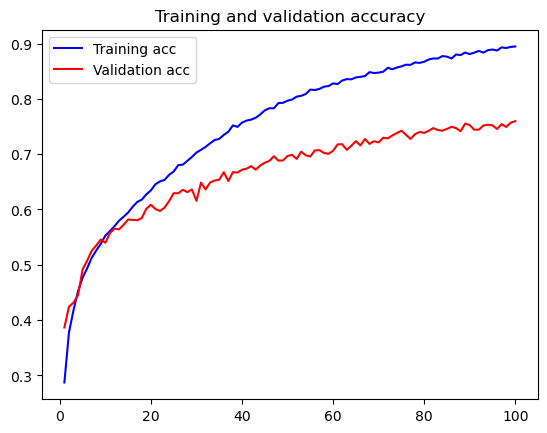

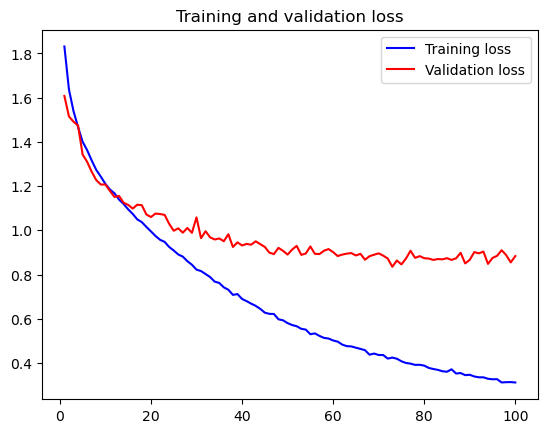

In [ ]:
# 3rd run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Attempt with resizing images to 224x224x3

As next we want to take into account that the VGG16 was trained on images of size 224x224x3 and our images only are of size 48x48x3 (after replicating the one greyscale channel to get all three expected channels).

In order to be able to compare the performance of the model with scaled images, we use the same settings as in first run.

--> Code does not run but results in a 'ResourceExhaustedError'.


In [54]:
# 4rth run: Define hyperparameters reduce to 10 epochs again
input_shape = (224, 224, 3)              # adjusted for the resized images
#input_shape = (48, 48, 3)
num_classes = 7
learning_rate = 0.0001
batch_size = 32                          # first attempt
batch_size = 16                          # reduced from 32 to 16 to be able to run the resizing of the images
epochs = 10

In [55]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

def resize_images(x):
    x= Image.fromarray(x)
    x = x.resize((224,224))
    x=np.array(x)
    return x

X_train_resized = np.array([resize_images(x) for x in X_train_rgb])
X_val_resized = np.array([resize_images(x) for x in X_val_rgb])

While googeling for better alternatives, I found an article indicating, that images not necessarily have to be resized.
https://datascience.stackexchange.com/questions/47851/how-to-input-different-sized-images-into-transfer-learning-network


# Fourth run: 4 trainable layers at the end, adapting additional layers, 100 epochs

dropout = 0.5 (before = 0.3)  
add L2-regularization  
epochs = 100   (as before)

In [56]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

In [57]:
# 4th run: Define hyperparameters
input_shape = (224, 224, 3)
num_classes = 7
learning_rate = 0.001
batch_size = 32
epochs = 100

In [58]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_resized,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_val_resized,
    y=y_val_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [59]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [35]:
# 4th run: freeze layers at the beginning and fine-tune the last 4 layers in the base model
#for layer in base_model.layers[:-4]:
#    layer.trainable = False

In [62]:
for layer in base_model.layers[:-1]:
    layer.trainable = False


In [64]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [37]:
# 4th run: add custom layers for emotion classification
#x = Conv2D(128, (3,3),padding = 'same')(base_model.output)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = MaxPooling2D((1, 1))(x)
#x = Dropout(0.5)(x)                                                   # adapted 0.3 -> 0.5
#x = Flatten()(base_model.output)#(x)
##x = Dense(256, activation='relu')(x)
#x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)     # added L2-regulation
#x = Dropout(0.5)(x)
#output = Dense(num_classes, activation='softmax', )(x)

In [65]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [66]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
# Train the model
start = time.time()
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[early_stopping]
)

end = time.time()

Epoch 1/100
224/224 [==============================] - 104s 447ms/step - loss: 2.0824 - accuracy: 0.1414 - val_loss: 1.9284 - val_accuracy: 0.0777
Epoch 2/100
224/224 [==============================] - 103s 459ms/step - loss: 1.9298 - accuracy: 0.1745 - val_loss: 1.9045 - val_accuracy: 0.1689
Epoch 3/100
224/224 [==============================] - 101s 450ms/step - loss: 1.9008 - accuracy: 0.1818 - val_loss: 1.8831 - val_accuracy: 0.1858
Epoch 4/100
224/224 [==============================] - 99s 442ms/step - loss: 1.8917 - accuracy: 0.1878 - val_loss: 1.9064 - val_accuracy: 0.0642
Epoch 5/100
224/224 [==============================] - 103s 460ms/step - loss: 1.8853 - accuracy: 0.1921 - val_loss: 1.8774 - val_accuracy: 0.1047
Epoch 6/100
224/224 [==============================] - 106s 472ms/step - loss: 1.8798 - accuracy: 0.1983 - val_loss: 1.8688 - val_accuracy: 0.0980
Epoch 7/100
224/224 [==============================] - 102s 457ms/step - loss: 1.8738 - accuracy: 0.2026 - val_loss: 1.

In [ ]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))

# Duration of model-fit in minutes: 474.4977
# Duration of model-fit in minutes: 466.9881

Duration of model-fit in minutes: 466.9881


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

##  4th run:

Model: "model"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================  
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         589952    
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 1, 128)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
=================================================================  
Total params: 15,339,975  
Trainable params: 7,704,455  
Non-trainable params: 7,635,520  
_________________________________________________________________  



In [ ]:
# 4th run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

# Training Accuracy: 0.9001
# Validation Accuracy: 0.7644
# Training Loss: 2.5809
# Validation Accuracy: 2.3178

#Training Accuracy: 0.8729
#Validation Accuracy: 0.7425
#Training Loss: 2.2153
#Validation Accuracy: 1.9925

Training Accuracy: 0.8729
Validation Accuracy: 0.7425 

Training Loss: 2.2153
Validation Accuracy: 1.9925


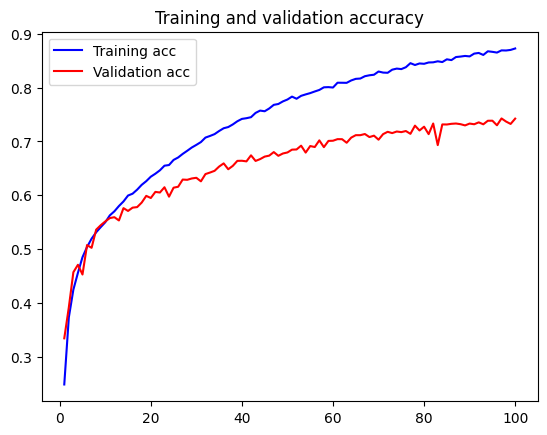

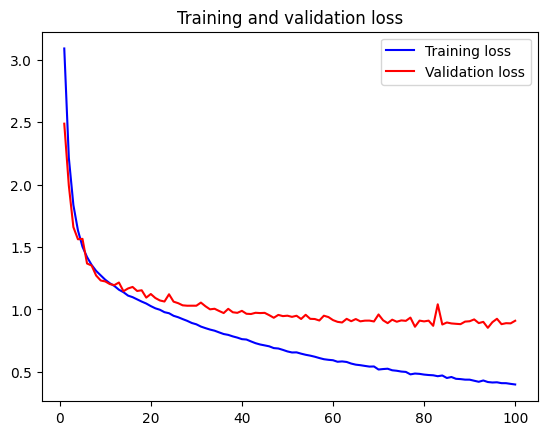

In [ ]:
# 4th run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Save the model for future inference
# run locally
#model.save('4tht_run_VGG16_model.h5')
# run on colab
model.save('../Model/4tht_run_VGG16_model.h5')

# Fifth run: 4 trainable layers at the end, adapting additional layers, 100 epochs


Conv2D: less filters, only 64
Dens: reduce to 128 neurons  
Dropout to 0.7  
L2 strength to 0.001  

In [22]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_train_rgb = np.repeat(X_train, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

In [ ]:
# 5th run: Define hyperparameters
input_shape = (48, 48, 3)
num_classes = 7
learning_rate = 0.0001
batch_size = 32
epochs = 100

In [ ]:
# train and validation-generator
train_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow(
    x=X_train_rgb,
    y=y_train_cat,
    batch_size=batch_size,
    shuffle=False,   #as no need to shuffle validation data
    subset='validation'
)

In [ ]:
# Load the pretrained MobileNetV2 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# 5th run: freeze layers at the beginning and fine-tune the last 4 layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# 5th run: add custom layers for emotion classification
x = Conv2D(64, (3,3),padding = 'same')(base_model.output)              # from 128 to 64 filters
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Dropout(0.7)(x)                                                    # 0.5 to 0.7
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)     # 256 to 128 neurons, L2 dtrength 0.01 to 0.001
x = Dropout(0.7)(x)                                                    # 0.5 to 0.7
output = Dense(num_classes, activation='softmax', )(x)

In [ ]:
# Create the emotion classifier model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
start = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

end = time.time()

Epoch 1/100
1102/1102 [==============================] - 273s 246ms/step - loss: 2.0931 - accuracy: 0.1644 - val_loss: 1.9760 - val_accuracy: 0.2124
Epoch 2/100
1102/1102 [==============================] - 278s 252ms/step - loss: 1.9403 - accuracy: 0.2386 - val_loss: 1.8504 - val_accuracy: 0.2906
Epoch 3/100
1102/1102 [==============================] - 279s 253ms/step - loss: 1.8524 - accuracy: 0.2971 - val_loss: 1.7164 - val_accuracy: 0.3619
Epoch 4/100
1102/1102 [==============================] - 273s 248ms/step - loss: 1.7740 - accuracy: 0.3360 - val_loss: 1.7526 - val_accuracy: 0.3306
Epoch 5/100
1102/1102 [==============================] - 275s 250ms/step - loss: 1.7088 - accuracy: 0.3644 - val_loss: 1.5823 - val_accuracy: 0.4067
Epoch 6/100
1102/1102 [==============================] - 274s 248ms/step - loss: 1.6562 - accuracy: 0.3880 - val_loss: 1.5256 - val_accuracy: 0.4344
Epoch 7/100
1102/1102 [==============================] - 274s 248ms/step - loss: 1.6118 - accuracy: 0.4048

Epoch 56/100
1102/1102 [==============================] - 279s 253ms/step - loss: 1.0041 - accuracy: 0.6534 - val_loss: 1.0279 - val_accuracy: 0.6294
Epoch 57/100
1102/1102 [==============================] - 276s 250ms/step - loss: 1.0009 - accuracy: 0.6557 - val_loss: 1.0340 - val_accuracy: 0.6283
Epoch 58/100
1102/1102 [==============================] - 276s 250ms/step - loss: 0.9961 - accuracy: 0.6592 - val_loss: 1.0437 - val_accuracy: 0.6249
Epoch 59/100
1102/1102 [==============================] - 273s 248ms/step - loss: 0.9880 - accuracy: 0.6615 - val_loss: 1.0374 - val_accuracy: 0.6232
Epoch 60/100
1102/1102 [==============================] - 274s 248ms/step - loss: 0.9906 - accuracy: 0.6616 - val_loss: 1.0691 - val_accuracy: 0.6218
Epoch 61/100
1102/1102 [==============================] - 273s 248ms/step - loss: 0.9785 - accuracy: 0.6668 - val_loss: 1.0139 - val_accuracy: 0.6345
Epoch 62/100
1102/1102 [==============================] - 274s 248ms/step - loss: 0.9840 - accuracy:

In [ ]:
print('Duration of model-fit in minutes:', round((end-start)/60, 4))

# Duration of model-fit in minutes: 457.1054

Duration of model-fit in minutes: 457.1054


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## 5th run:

Model: "model"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================  
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 64)          294976    
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 1, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
=================================================================  
Total params: 15,019,143  
Trainable params: 7,383,751  
Non-trainable params: 7,635,392  
_________________________________________________________________  

In [ ]:
# 5th run: metrics overview
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][1]
val_loss = history.history['val_loss'][1]

print('Training Accuracy:', round(acc,4))
print('Validation Accuracy:', round(val_acc,4), '\n')

print('Training Loss:', round(loss, 4))
print('Validation Accuracy:', round(val_loss,4))

# Training Accuracy: 0.7455
# Validation Accuracy: 0.6748

# Training Loss: 1.9403
# Validation Accuracy: 1.8504

Training Accuracy: 0.7455
Validation Accuracy: 0.6748 

Training Loss: 1.9403
Validation Accuracy: 1.8504


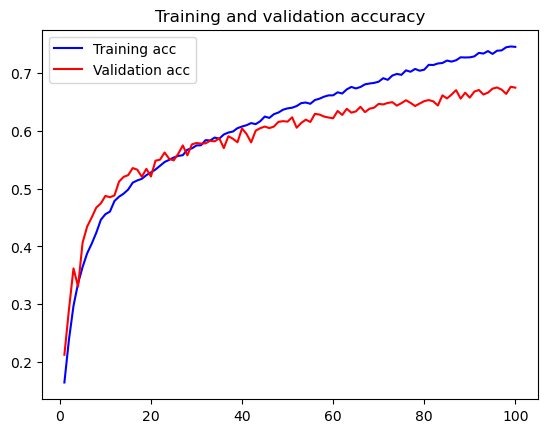

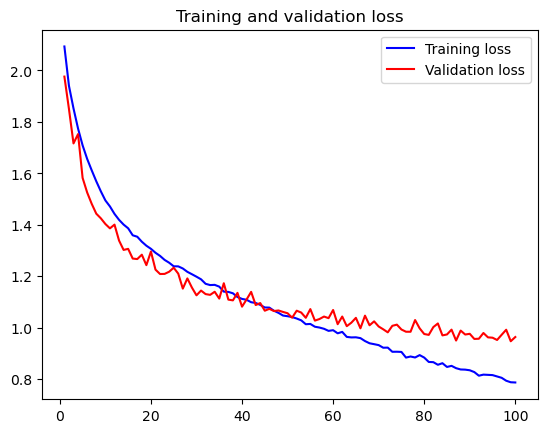

In [ ]:
# 5th run metrics plot:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Save the model for future inference
# run locally
#model.save('5th_run_VGG16_model.h5')
# run on colab
model.save('../Model/5th_run_VGG16_model.h5')